# **Flight Delay As A Classification Problem**

In this notebook I tried to model the flight cancellation as a multiclass classification problem.I am using different classification algorithims taught in class to decide how much the flight will be delayed.
The code bellow are structured in following way 


1.   Data Visualisation 
2.   Data manipulation
3.   Modeling 
4.   Comparision 





# **Data Visualization**

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn import datasets
import random
from collections import defaultdict
from scipy.sparse import csr_matrix,hstack
from sklearn.utils import shuffle
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
drive.mount('/content/drive/',force_remount=True)
!ls "/content/drive/My Drive"

In [2]:
path='/content/drive/My Drive/flights.csv'
#Load the flights.csv file
dataset = pd.read_csv(path)
print(dataset.shape)
dataset.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(5819079, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The data set consist of 5819079 flights details recoreded in 2015. These flights are described by 31 attributes and they are as follow 


1.   **Year,Month,Day,Day Of Week**: Flight Dates
2.   **Airline, Tail No, Flight No**: Name of the Airline as assigned by US DOT
3.   **Origin Air port , Destination Airport** : Code given by IATA
4.   **Scheduled Departure , Scheduled Arrival** : Take off & Landing time as planned 
5.   **Departure Time, Arrival Time, Elaspped Time, AIr Time** : Actual take off, Landing time and the time taken 
6.   **Departure Delay , Arrival Delay** : Difference in Minute between actual and real times 
7. **Air System Delay , Airline Delay, Security Delay, Late Aircraft Delay, Weather Delay** : in minutes
8. **Distance** : In miles from source to destination 
9. **Taxi Out, Taxi in time** : In minutes
10. **Wheels On , Wheels of time** : In minutes
11. **Diverted**: If dieverted from the destination Airport 
12. **Cancelled , Cancellation Reason** : Whether the flight being cancelled or not. If Yes then what is the reason 
 





In [55]:
# Only taking the data for the 1st two months
df = dataset[dataset['MONTH']<3]
df.shape

(899159, 31)

As I dont have infrastructure to process such a large dataset, I decided to limit my dataset only to the Month januuary & February of 2015. It has 899159 flight information.

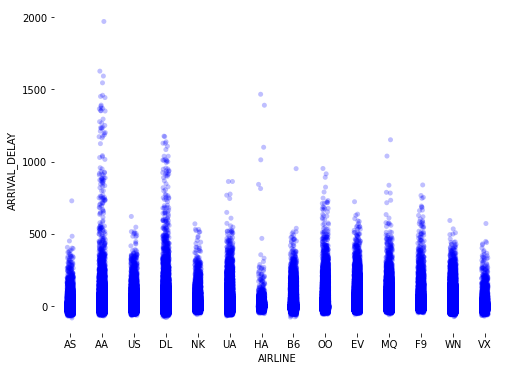

Average Delay for all the Airlines: 6.995502361578209 minutes


In [39]:
axis = plt.subplots(figsize=(8,6))
sns.despine(bottom=True, left=True)
# Observations with Scatter Plot
sns.stripplot(y="ARRIVAL_DELAY", x="AIRLINE",data = df,color='blue',edgecolor="black", alpha=.25)
plt.show()
print('Average Delay for all the Airlines: ' + str(np.mean(df['ARRIVAL_DELAY'])) + ' minutes')

The above graph shows the Arrival delay for all the air lines. As we can see the average delay for all the airline is close to 7 minutes

# **Data Maniupilation** 

The input data has 31 attributes which are not relevant always. As a first step we wanted to know which are the important variable that 'Arrival delay' is mostly correlated. The correlation with rest of the attributes gave us a clear Idea about the major attributes that impact the Arrival delay.

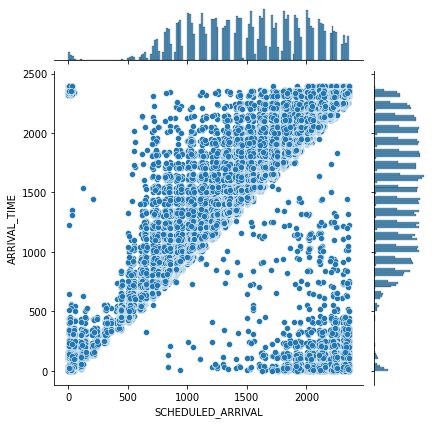

In [40]:
#joint plot of 'SCHEDULED_ARRIVAL' and 'ARRIVAL_TIME'
sns.jointplot(data=df,x='SCHEDULED_ARRIVAL',y='ARRIVAL_TIME')

ARRIVAL_DELAY          1.000000
DEPARTURE_DELAY        0.939508
AIRLINE_DELAY          0.594434
LATE_AIRCRAFT_DELAY    0.524247
WEATHER_DELAY          0.322495
TAXI_OUT               0.277223
AIR_SYSTEM_DELAY       0.244123
DEPARTURE_TIME         0.158613
WHEELS_OFF             0.158136
TAXI_IN                0.155655
SCHEDULED_DEPARTURE    0.082332
SCHEDULED_ARRIVAL      0.076924
WHEELS_ON              0.070731
ARRIVAL_TIME           0.062946
FLIGHT_NUMBER          0.039972
ELAPSED_TIME           0.038161
MONTH                  0.030341
SECURITY_DELAY         0.009031
DAY_OF_WEEK           -0.006896
AIR_TIME              -0.013525
DISTANCE              -0.031730
SCHEDULED_TIME        -0.035582
DAY                   -0.068885
DIVERTED                    NaN
CANCELLED                   NaN
Name: ARRIVAL_DELAY, dtype: float64


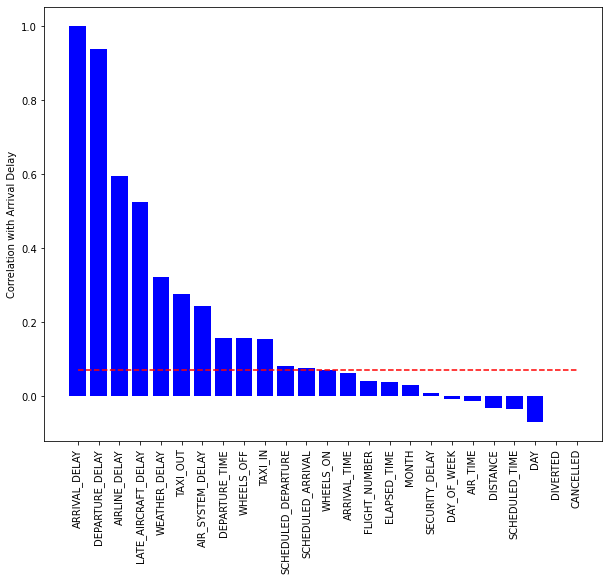

In [41]:
AA=df[df.columns[1:]].corr()['ARRIVAL_DELAY'][:].sort_values(ascending=False)
print(AA)
AA.to_numpy
plt.figure(figsize=[10,8])
plt.bar(AA.index,AA.values,color='blue')
plt.xticks(rotation='vertical')
plt.ylabel('Correlation with Arrival Delay')
plt.plot(np.zeros(len(AA.index))+0.07,'r--')

As we can see there are attributes that re poorly correlated and has less influence on Arrival delay. Based on correlation score we dropped those columns from our data set. 

In [56]:
df=df.drop(['YEAR','MONTH','SCHEDULED_TIME','AIR_TIME','DAY_OF_WEEK','DAY','AIRLINE','DIVERTED','ELAPSED_TIME','DISTANCE','TAIL_NUMBER','FLIGHT_NUMBER','CANCELLATION_REASON','WHEELS_OFF','CANCELLED','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL','ORIGIN_AIRPORT', 'DESTINATION_AIRPORT' ], axis=1)

In [57]:
df.columns
df.shape

(899159, 12)

The data matrix that we have is sparse as for many flights we dont have information for all the selected attributes. We replaced those unavailable data points by the mean of that attribute over the entaire data set.

In [58]:
#Identifying Null values in dataset
df.isna().sum()

DEPARTURE_TIME          31716
DEPARTURE_DELAY         31716
TAXI_OUT                32288
WHEELS_ON               33093
TAXI_IN                 33093
ARRIVAL_TIME            33093
ARRIVAL_DELAY           34483
AIR_SYSTEM_DELAY       708029
SECURITY_DELAY         708029
AIRLINE_DELAY          708029
LATE_AIRCRAFT_DELAY    708029
WEATHER_DELAY          708029
dtype: int64

In [59]:
#Replacing Null values with mean
df =df.fillna(df.mean())

In [60]:
#Identifying Null values in dataset
df.isna().sum()

DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_ON              0
TAXI_IN                0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
dtype: int64

As we wanted to frame the flight delay as a classification problem we binned the Arrival delay into 4 classes 


1. Flights with Arrival delay less than 30 min 
2. Flights with Arrival delay between 30 Min to 2Hr 
3. Flights with Arrival delay between 1Hr to 2Hr
4. Flights with Arrival delay more than 2Hr



In [61]:
#using the condition if 'ARRIVAL_DELAY' is greater than 15 then imputing 1 else 0.
result=[]
Class_Name=['< 30Min','30Min - 1Hr ','1Hr - 2Hr','>2Hr']
for row in df['ARRIVAL_DELAY']:
    if row < 30 :
        result.append(0)
    elif (row > 30) and (row < 60):
        result.append(1)
    elif (row > 60) and (row < 120):
        result.append(2)
    else:
        result.append(3) 

In [63]:
df['result'] = result

0    781528
1     56234
2     37281
3     24116
Name: result, dtype: int64


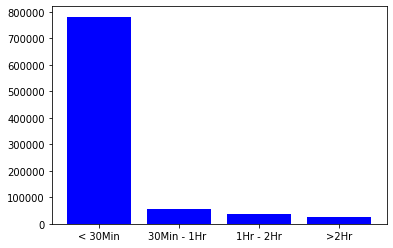

In [64]:
# Unique counts of 'result' columns 
plt.bar(Class_Name,df['result'].value_counts(),color='blue')
print(df['result'].value_counts())

In [65]:
df=df.drop(['ARRIVAL_DELAY'],axis=1)
df.columns
#Preview after adding new column 'result'

Index(['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_ON', 'TAXI_IN',
       'ARRIVAL_TIME', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'result'],
      dtype='object')

In [66]:
df.shape
df.head()

,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_ON,TAXI_IN,ARRIVAL_TIME,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,result
0,2354.0,-11.0,21.0,404.0,4.0,408.0,13.745765,0.059017,17.897844,22.716387,3.528237,0
1,2.0,-8.0,12.0,737.0,4.0,741.0,13.745765,0.059017,17.897844,22.716387,3.528237,0
2,18.0,-2.0,16.0,800.0,11.0,811.0,13.745765,0.059017,17.897844,22.716387,3.528237,0
3,15.0,-5.0,15.0,748.0,8.0,756.0,13.745765,0.059017,17.897844,22.716387,3.528237,0
4,24.0,-1.0,11.0,254.0,5.0,259.0,13.745765,0.059017,17.897844,22.716387,3.528237,0


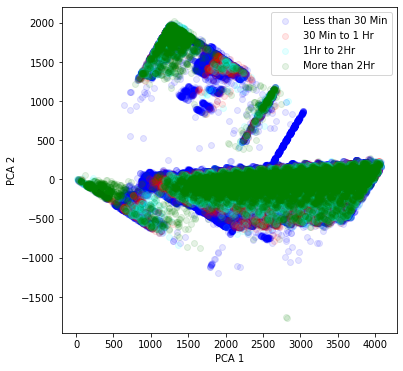

In [67]:
D=df.drop(['result'],axis=1)
PCA=TruncatedSVD(2)
L2_NormalizedPCA=PCA.fit_transform(D)
dfPCA=pd.DataFrame(L2_NormalizedPCA)
X=dfPCA[0]
Z=dfPCA[1]
Y=np.array(result)
plt.figure(figsize=[6,6])
plt.scatter(X[Y==0],Z[Y==0],color='blue',alpha=0.1,label='Less than 30 Min')
plt.scatter(X[Y==1],Z[Y==1],color='red',alpha=0.1,label='30 Min to 1 Hr')
plt.scatter(X[Y==2],Z[Y==2],color='cyan',alpha=0.1,label='1Hr to 2Hr')
plt.scatter(X[Y==3],Z[Y==3],color='green',alpha=0.1,label='More than 2Hr')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()

In order to visualize we tried to project the data into 1st two princepal components and labaled them as per the 4 classes that we bin into. 

# **Modeling**

After pre-processing I tried following classification Algorithim 


1. Decision Tree
2. Random Forest 
3. Multiclass Logistic Regression 
4. Naive Bayes
5. Support Vector Machine 

To verify that all my models are being generalised, I devided my input data Trainning and Testing data with 70/30 split


**Splitiing the DATA into Trainning & Testing set (70/30 split)**

In [68]:
#Splitting Dataset into Training and Testing with 80:20 ratio and with random_state = 42
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_roc_curve
df=df.values
X, y = df[:,:-1], df[:,-1]
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
scaled_features = StandardScaler().fit_transform(X_Train, X_Test)

In [84]:
# Model Performance 
Model=[]
Train_Acc=[]
Test_Acc=[]
def store_Model(model,a,b):
  Model.append(model)
  Train_Acc.append(round(a,3))
  Test_Acc.append(round(b,3))

**Decision Tree**

In [85]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
from sklearn.tree import DecisionTreeClassifier
CLF=DecisionTreeClassifier(max_depth=8)
CLF.fit(X_Train,Y_Train)
Pred_Y=CLF.predict(X_Test)

Accuracy of Decision Tree on Test Data :0.9786801014279994
              precision    recall  f1-score   support

     < 30Min       0.99      1.00      0.99    156257
30Min - 1Hr        0.88      0.84      0.86     11245
   1Hr - 2Hr       0.91      0.91      0.91      7442
        >2Hr       0.96      0.82      0.88      4888

    accuracy                           0.98    179832
   macro avg       0.93      0.89      0.91    179832
weighted avg       0.98      0.98      0.98    179832



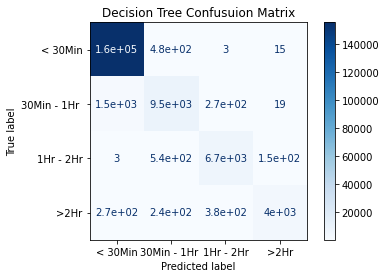

In [86]:
acc_Train=accuracy_score(CLF.predict(X_Train),Y_Train)
acc_Test=accuracy_score(Pred_Y,Y_Test)
plot_confusion_matrix(CLF,X_Test,Y_Test,display_labels=Class_Name,cmap=plt.cm.Blues)
plt.title('Decision Tree Confusuion Matrix')
print('Accuracy of Decision Tree on Test Data :' + str(accuracy_score(Pred_Y,Y_Test)))
print(classification_report(Y_Test,Pred_Y,target_names=Class_Name))
store_Model('Decision Tree',acc_Train,acc_Test)

 **Random Forest**

In [87]:
from sklearn.ensemble import RandomForestClassifier
CLF=RandomForestClassifier(max_depth=8)
CLF.fit(X_Train,Y_Train)
Pred_Y=CLF.predict(X_Test)

Accuracy of Random Forest on Test Data :0.9757329062680724
              precision    recall  f1-score   support

     < 30Min       0.99      1.00      0.99    156257
30Min - 1Hr        0.86      0.82      0.84     11245
   1Hr - 2Hr       0.90      0.91      0.91      7442
        >2Hr       0.98      0.74      0.85      4888

    accuracy                           0.98    179832
   macro avg       0.93      0.87      0.90    179832
weighted avg       0.98      0.98      0.98    179832



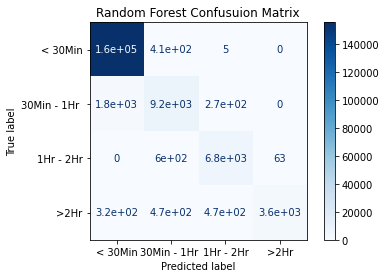

In [88]:
acc_Train=accuracy_score(CLF.predict(X_Train),Y_Train)
acc_Test=accuracy_score(Pred_Y,Y_Test)
plot_confusion_matrix(CLF,X_Test,Y_Test,display_labels=Class_Name,cmap=plt.cm.Blues)
plt.title('Random Forest Confusuion Matrix')
print('Accuracy of Random Forest on Test Data :' + str(accuracy_score(Pred_Y,Y_Test)))
print(classification_report(Y_Test,Pred_Y,target_names=Class_Name))
store_Model('Random Forest',acc_Train,acc_Test)

**Multinomial Logistic Regression**

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
CLF=LogisticRegression(multi_class='multinomial',max_iter=100)
CLF.fit(X_Train,Y_Train)
Pred_Y=CLF.predict(X_Test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of Logistic Regression on Test Data:0.9175897504337381
              precision    recall  f1-score   support

     < 30Min       0.96      0.98      0.97    156257
30Min - 1Hr        0.49      0.40      0.44     11245
   1Hr - 2Hr       0.59      0.63      0.61      7442
        >2Hr       0.74      0.59      0.65      4888

    accuracy                           0.92    179832
   macro avg       0.70      0.65      0.67    179832
weighted avg       0.91      0.92      0.91    179832



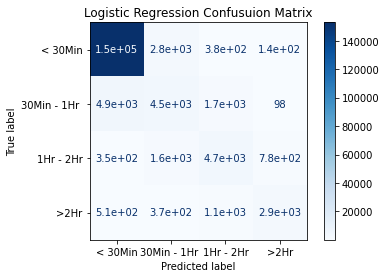

In [90]:
acc_Train=accuracy_score(CLF.predict(X_Train),Y_Train)
acc_Test=accuracy_score(Pred_Y,Y_Test)
plot_confusion_matrix(CLF,X_Test,Y_Test,display_labels=Class_Name,cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusuion Matrix')
print('Accuracy of Logistic Regression on Test Data:' + str(accuracy_score(Pred_Y,Y_Test)))
print(classification_report(Y_Test,Pred_Y,target_names=Class_Name))
store_Model('Logistic Regression',acc_Train,acc_Test)

**Naive Bayes**

In [91]:
from sklearn.naive_bayes import GaussianNB
CLF=GaussianNB()
CLF.fit(X_Train,Y_Train)
Pred_Y=CLF.predict(X_Test)

Accuracy of Naive Bayes on Test Data :0.8921437786378398
              precision    recall  f1-score   support

     < 30Min       1.00      0.91      0.95    156257
30Min - 1Hr        0.38      0.91      0.54     11245
   1Hr - 2Hr       0.76      0.71      0.73      7442
        >2Hr       0.82      0.59      0.69      4888

    accuracy                           0.89    179832
   macro avg       0.74      0.78      0.73    179832
weighted avg       0.94      0.89      0.91    179832



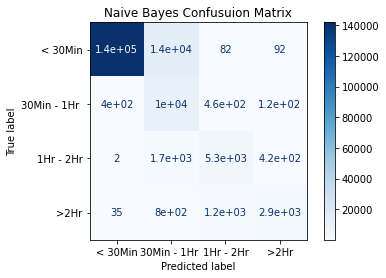

In [92]:
acc_Train=accuracy_score(CLF.predict(X_Train),Y_Train)
acc_Test=accuracy_score(Pred_Y,Y_Test)
plot_confusion_matrix(CLF,X_Test,Y_Test,display_labels=Class_Name,cmap=plt.cm.Blues)
plt.title('Naive Bayes Confusuion Matrix')
print('Accuracy of Naive Bayes on Test Data :' + str(accuracy_score(Pred_Y,Y_Test)))
print(classification_report(Y_Test,Pred_Y,target_names=Class_Name))
store_Model('Naive Bayes',acc_Train,acc_Test)

**XGBoost Classifier**

In [94]:
from xgboost import XGBClassifier
CLF=XGBClassifier(learning_rate=0.01,max_depth=8)
CLF.fit(X_Train,Y_Train)
Pred_Y=CLF.predict(X_Test)

Accuracy of XGBoost on Test Data :0.9857589305574092
              precision    recall  f1-score   support

     < 30Min       0.99      1.00      1.00    156257
30Min - 1Hr        0.91      0.93      0.92     11245
   1Hr - 2Hr       0.95      0.94      0.95      7442
        >2Hr       0.98      0.82      0.89      4888

    accuracy                           0.99    179832
   macro avg       0.96      0.92      0.94    179832
weighted avg       0.99      0.99      0.99    179832



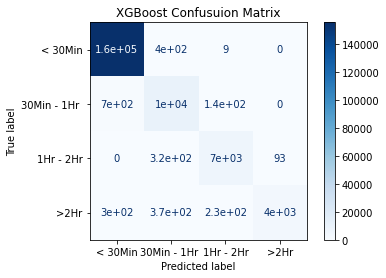

In [95]:
acc_Train=accuracy_score(CLF.predict(X_Train),Y_Train)
acc_Test=accuracy_score(Pred_Y,Y_Test)
plot_confusion_matrix(CLF,X_Test,Y_Test,display_labels=Class_Name,cmap=plt.cm.Blues)
plt.title('XGBoost Confusuion Matrix')
print('Accuracy of XGBoost on Test Data :' + str(accuracy_score(Pred_Y,Y_Test)))
print(classification_report(Y_Test,Pred_Y,target_names=Class_Name))
store_Model('XGBoost',acc_Train,acc_Test)

**Support Vector Machine**

In [93]:
from sklearn.svm import SVC
CLF=SVC(kernel="rbf",C=0.1)
CLF.fit(X_Train,Y_Train)
Pred_Y=CLF.predict(X_Test)

In [ ]:
from sklearn.metrics import plot_confusion_matrix,accuracy_score,classification_report
acc_Train=accuracy_score(CLF.predict(X_Train),Y_Train)
acc_Test=accuracy_score(Pred_Y,Y_Test)
plot_confusion_matrix(CLF,X_Test,Y_Test,display_labels=Class_Name,cmap=plt.cm.Blues)
plt.title('SVM Confusuion Matrix')
print('Accuracy of SVM on Test Data :' + str(accuracy_score(Pred_Y,Y_Test)))
print(classification_report(Y_Test,Pred_Y,target_names=Class_Name))
store_Model('SVM',acc_Train,acc_Test)

# **Final Comparision**

In [96]:
Performance=pd.DataFrame({'Model' : Model,'Train_Accuracy' : Train_Acc,'Test_Accuracy' : Test_Acc})
Performance.sort_values(by=['Test_Accuracy','Train_Accuracy'],ascending =False)

,Model,Train_Accuracy,Test_Accuracy
4,XGBoost,0.986,0.986
0,Decision Tree,0.979,0.979
1,Random Forest,0.976,0.976
2,Logistic Regression,0.919,0.918
3,Naive Bayes,0.891,0.892


Looking at the comparision table it seems all the model generalizes well but XGBoost gave better accuracy compared to other models. The performance of Naive bayes and I think its because of the gaussing approximation(for prior) that we have taken. Most of the arrival/delay process usually follow poissions distribution and as a next step we will explore the Naive Bayes with Poisssion distribution being as a prior for the model.